# Overview - Classifier based anomaly detection 

Deep neural networks (DNNs)은 test sample들이 similar distribution(i.e., in-distribution)에 있을 경우에는 잘 작동합니다. (ex. Image classifier)

- 하지만 만약 sample이 out-of-distribution로부터 왔다면 DNNs은 제대로 작동하지 못합니다.

- 따라서 test sample이 in-distribution인지, out-of-distribution인지 탐지해야 됩니다.


## How?

<img src="./images/Classifier_overview.png" width="1000px" title="Classifier Overview" />


Threshold-based classification, 즉 임계값을 바탕으로 분류해 이를 수행합니다.

여기서는 classifier를 이용해 self-supervised에 초점을 두고 진행합니다.

## 0 Installing library & datasets

터미널에서 아래 명령어를 차례대로 입력해 conda 환경을 설정합니다.

- wget https://repo.anaconda.com/archive/Anaconda3-2021.11-Linux-x86_64.sh

- bash Anaconda3-2021.11-Linux-x86_64.sh

Open new terminal (Top menu > Terminal > New Terminal), create conda environment

- conda create -n anomaly_detection python=3.6.9

Connect to conda environment

- Select Kernel > Python environments > anomaly_detection

In [1]:
# Install Library
!pip3 install torch
!pip3 install torchvision
!pip3 install numpy
!pip3 install tqdm
!pip3 install matplotlib
!pip3 install scikit-learn

In [2]:
# Import Library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and save MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./datasets', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./datasets', train=False, transform=transform, download=True)

# Download and save CIFAR-10 dataset
cifar_train = torchvision.datasets.CIFAR10(root='./datasets', train=True, transform=transform, download=True)
cifar_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


# 1. Supervsied learning



## 1.1. Classifier preliminaries

---

- Classification은 unknown posterior distribution, i.e., P(Y|X)를 찾는 것이었습니다. 

- 이때 posterior distribution은 DNN을 이용한 softmax classifier로 다음과 같이 쓸 수 있습니다.

$$ P(y=c|\mathbf{x}) = \frac{\exp ( \bold{w}_{c}^{T}f(x)+b_{c})}{ \sum_{c'}\exp (\bold{w}_{c'}^{T}f(x)+b_{c'})}$$

- 먼저 간단한 classifier를 정의하고 학습합니다.
  
- 학습한 classifier를 통해 confidence score를 계산합니다.
  
- Evaluation metric을 통해 confidenc score의 결과를 확인합니다.


### 1.1.1 Classifier

우선 MNIST dataset에 대해 간단한 classifier를 정의합니다.

In [4]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    """
    TODO: Define linear layers
    Input image shape: (28, 28)
    Hidden layer dimension: 16
    Final Output: 2 classes, 0 as anomaly(out-of-distribution) and other digit 0 ~ 9 as in-distribution
    HINT: nn.Linear(), https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    """
    self.fc1 = nn.Linear(28*28, 16)
    self.fc2 = nn.Linear(16, 2)

  def forward(self, x):
    """
    TODO: Define the forward functions
    1. Flatten the image (HINT: torch.view(), https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
    2. Apply activation function torch.relu() to the results of fc1 and fc2
    """
    x = x.view(-1, 28*28)  
    hidden = torch.relu(self.fc1(x))
    out = torch.relu(self.fc2(hidden))
    return out, hidden
  


### 1.1.2 MNIST Dataset
- MNIST는 숫자 0~9의 이미지에 관한 데이터셋입니다.
 
- 여기서 0을 anomaly, i.e., out-of-distribution data로 생각해 label 1로,
  나머지 숫자 1~9를 in-distrubution으로 생각해 label 0으로 분류합니다.

In [5]:
# NOTE: Set labels for anomaly detection
mnist_train.targets = torch.where(mnist_train.targets == 0, torch.tensor(1), torch.tensor(0))
mnist_test.targets = torch.where(mnist_test.targets == 0, torch.tensor(1), torch.tensor(0))

Normal data samples:


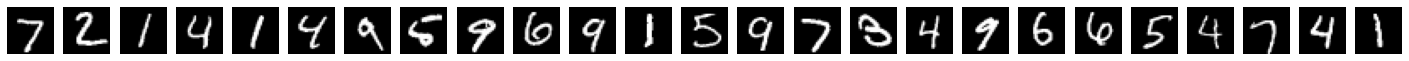

Anomaly data samples:


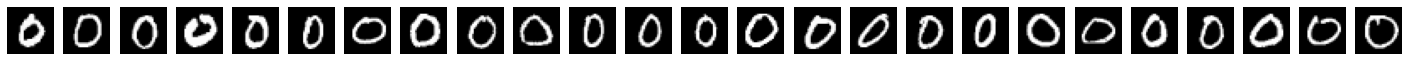

In [6]:
# NOTE: Visualize normal & anomaly datas
mnist_test_normal_indices = (mnist_test.targets != 1).nonzero().squeeze()
mnist_test_anomaly_indices = (mnist_test.targets == 1).nonzero().squeeze()

number_of_samples = 25

plt.figure(figsize=(25, 5))
for i, idx in enumerate(mnist_test_normal_indices[:number_of_samples]):
    plt.subplot(1, number_of_samples, i + 1)
    plt.imshow(mnist_test[idx][0].numpy().reshape(28,28), cmap='gray')
    plt.axis('off')
print('Normal data samples:')
plt.show()

plt.figure(figsize=(25, 5))
for i, idx in enumerate(mnist_test_anomaly_indices[:number_of_samples]):
    plt.subplot(1, number_of_samples, i + 1)
    plt.imshow(mnist_test[idx][0].numpy().reshape(28,28), cmap='gray')
    plt.axis('off')
print('Anomaly data samples:')
plt.show()


### 1.1.3 Training a simple classifier

- 위에서 정의한 classifier를 훈련합니다.
- 훈련한 model을 저장해 나중에 사용할 수 있도록 합니다.


In [7]:
# NOTE: Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)
min_gram_value = float('inf')
max_gram_value = float('-inf')

# NOTE: Initialize the classifier and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# NOTE: Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # NOTE: calculated gram matrix value        
        # if epoch == 9:
        #     with torch.no_grad():
        #         _, hidden_features = classifier(images)
        #         for idx, feature in enumerate(hidden_features):
        #             if labels[idx].item() == 0:
        #                 feature = feature.unsqueeze(0)
        #                 gram_matrix = torch.matmul(feature, feature.t())
        #                 min_gram_value = min(min_gram_value, gram_matrix.min().item())
        #                 max_gram_value = max(max_gram_value, gram_matrix.max().item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# NOTE: Save the trained model
torch.save(classifier.state_dict(), 'classifier_trained.pth')
print("Trained model saved as 'classifier_trained.pth'")

 10%|█         | 1/10 [00:10<01:33, 10.35s/it]

Epoch [1/10], Loss: 0.0570


 20%|██        | 2/10 [00:20<01:22, 10.31s/it]

Epoch [2/10], Loss: 0.0292


 30%|███       | 3/10 [00:30<01:11, 10.27s/it]

Epoch [3/10], Loss: 0.0033


 40%|████      | 4/10 [00:41<01:01, 10.26s/it]

Epoch [4/10], Loss: 0.0068


 50%|█████     | 5/10 [00:51<00:51, 10.28s/it]

Epoch [5/10], Loss: 0.0336


 60%|██████    | 6/10 [01:01<00:41, 10.28s/it]

Epoch [6/10], Loss: 0.0012


 70%|███████   | 7/10 [01:11<00:30, 10.28s/it]

Epoch [7/10], Loss: 0.0082


 80%|████████  | 8/10 [01:22<00:20, 10.26s/it]

Epoch [8/10], Loss: 0.0009


 90%|█████████ | 9/10 [01:32<00:10, 10.29s/it]

Epoch [9/10], Loss: 0.0010


100%|██████████| 10/10 [01:42<00:00, 10.29s/it]

Epoch [10/10], Loss: 0.0033
Trained model saved as 'classifier_trained.pth'
Minmimum gram value: inf
Maximum gram value: -inf


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = Classifier().to(device)

# NOTE: 직접 학습한 모델을 불러오는 경우
# classifier.load_state_dict(torch.load('classifier_trained.pth'))
# NOTE: pretrained model을 불러오는 경우
classifier.load_state_dict(torch.load('classifier_pretrained.pth'))
min_gram_value = 70
max_gram_value = 1500

classifier.eval()

Classifier(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

### 1.1.4 Confidence score

이제 classifier로 구한 posterior distribution에서 아래의 두 가지 방법으로 confidence score를 구할 수 있습니다.
1. Posterior distribution 값들 중 최댓값을 사용합니다
$$ \max_{c} \ P(y=c|\mathbf{x}) $$
2. Posterior distribution의 entropy를 활용합니다
$$ H = \sum_{y}-P(y|\mathbf{x}) \log P(y|\mathbf{x}) $$

In [9]:
def calculate_confidence_scores(outputs):
  posterior_probs = outputs
  """
  TODO: posterior_probs를 이용하여 max_prob과 entropy를 계산하세요.
  1. Maximum value in posterior distribution
  HINT: torch.max() 함수를 사용하세요, https://pytorch.org/docs/stable/generated/torch.max.html#torch-max
  """
  max_prob_value, max_prob_idx = torch.max(posterior_probs, dim=1)
  
  """
  2. Entropy of the posterior distribution
  HINT: torch.log2() 함수를 사용하세요, https://pytorch.org/docs/stable/generated/torch.log2.html
  로그 함수는 양수만을 입력해야 되므로, 혹시 모를 경우를 대비해 임의의 작은 값을 더해줘도 됩니다.
  """
  entropy = -torch.sum(posterior_probs * torch.log2(posterior_probs + 1e-10), dim=1)
  
  return max_prob_idx, entropy

### 1.1.5 Visualization

앞에서 구현한 두 가지 confidenc score로 anomaly detection 시각화합니다.

- test sample 20개에 대한 confidence score를 확인합니다.

- 현재 상황에서 0을 anomaly, i.e., out-of-distribution, 1 ~ 9 를 in-distribution으로 생각합니다.

tensor([[9.9998e-01, 2.0080e-05],
        [9.9941e-01, 5.8646e-04],
        [9.9997e-01, 2.5415e-05],
        [1.0872e-03, 9.9891e-01],
        [9.9943e-01, 5.7139e-04],
        [9.9994e-01, 5.8227e-05],
        [1.0000e+00, 5.4277e-07],
        [1.0000e+00, 5.3734e-07],
        [9.9836e-01, 1.6405e-03],
        [1.0000e+00, 1.7718e-08],
        [1.4516e-03, 9.9855e-01],
        [9.9954e-01, 4.5595e-04],
        [1.0000e+00, 9.1122e-08],
        [1.5485e-04, 9.9985e-01],
        [1.0000e+00, 1.0927e-07],
        [9.9995e-01, 4.5981e-05],
        [9.9994e-01, 6.2569e-05],
        [9.9990e-01, 1.0431e-04],
        [9.9997e-01, 3.4562e-05],
        [1.0000e+00, 3.7063e-06],
        [9.9953e-01, 4.7354e-04],
        [9.9999e-01, 1.4393e-05],
        [9.9980e-01, 1.9599e-04],
        [1.0000e+00, 3.0777e-06],
        [9.9964e-01, 3.6056e-04],
        [3.9766e-05, 9.9996e-01],
        [9.9985e-01, 1.4692e-04],
        [1.0000e+00, 9.4117e-07],
        [4.5375e-04, 9.9955e-01],
        [1.000

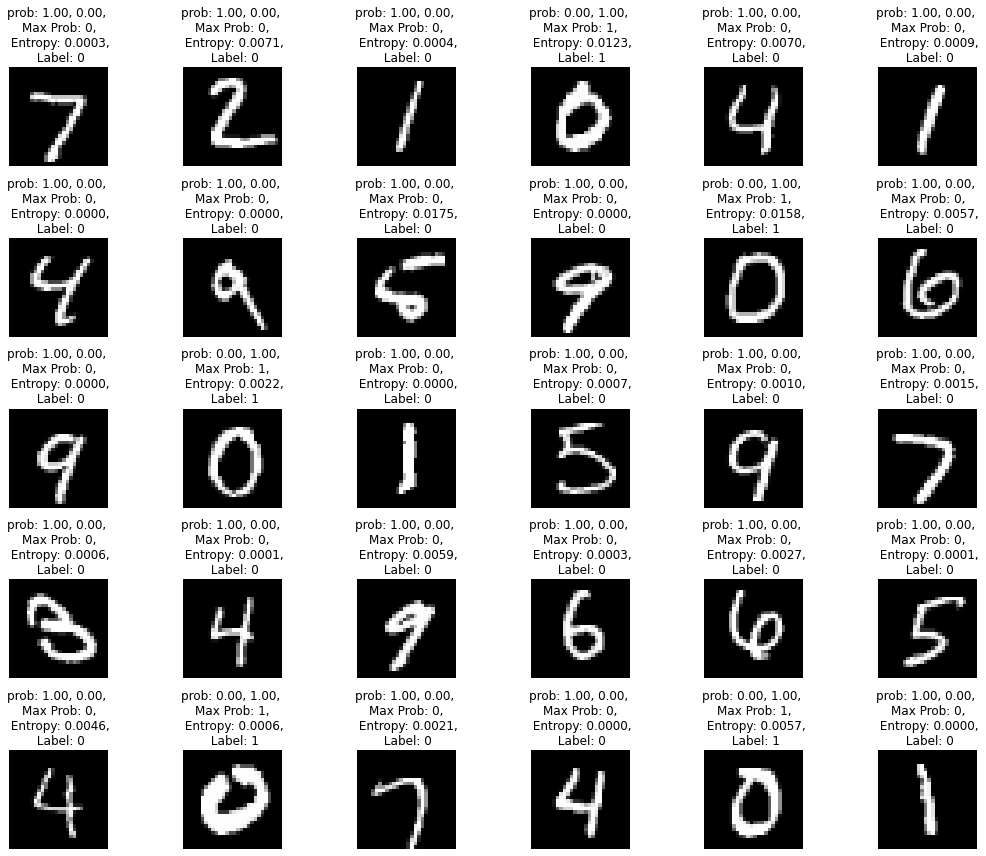

In [10]:
# Visualization of the anomaly detection classifier

test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=64, shuffle=False)

def visualization(test_loader):
    threshold = 0.8400

    num_anomalies_to_visualize = 30
    num_cols = 6
    num_rows = 5

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    with torch.no_grad():
        for images, labels in test_loader:
            output, _ = classifier(images.to(device))
            output = torch.softmax(output, dim=1)
            max_prob_idx, entropy = calculate_confidence_scores(output)
            print(output)
            
            for i, image in enumerate(images):
                if i >= num_anomalies_to_visualize:
                    break
                max_prob_idx, entropy = calculate_confidence_scores(output)
                plt.subplot(num_rows, num_cols, i + 1)
                plt.imshow(image.squeeze(), cmap='gray')
                plt.title(f'prob: {output[i][0].item():.2f}, {output[i][1].item():.2f}, \nMax Prob: {max_prob_idx[i].item()},\n Entropy: {entropy[i].item():.4f},\n Label: {labels[i].item()}')
                plt.axis('off')
            break

    plt.tight_layout()
    plt.show()
    
visualization(test_loader)


### 1.1.6 Evaluation metrics

Out-of-distribution을 얼마자 잘 하였는지 평가하기 위해 사용하는 지표 AUPR(Area under the Precision-Recall curve), AUROC(Area under ROC curve)가 있었습니다.

<img src="./images/Confusion_matrix.png" width="452px" title="Confusion_matrix" />
<img src="./images/AUPR_AUROC.png" width="1000px" title="AUPR_AUROC" />


In [11]:
def calculate_auroc_aupr(true_labels, predicted_probs):
    sorted_indices = np.argsort(predicted_probs)[::-1]
    true_labels_sorted = true_labels[sorted_indices]
    num_anomalies = np.sum(true_labels_sorted == 1)
    num_normals = len(true_labels_sorted) - num_anomalies
    """
    TODO: AUROC, AUPR 계산
    - true_labels_sorted: 올바르게 분류한 데이터들
    - num_anomalies: TP + FN
    - num_normals: FP + TN
    아래 값들을 바탕으로 true_positive, false_positive을 계산합니다.
    이후 AUROC를 계산하기 위한 tpr, fpr, 그리고 AUPR을 계산하기 위한 precision, recall을 계산합니다.
    HINT: np.cumsum(), https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
    """
    
    true_positive = np.cumsum(true_labels_sorted == 1)
    false_positive = np.cumsum(true_labels_sorted == 0)

    tpr = true_positive / num_anomalies
    fpr = false_positive / num_normals
    auroc = np.trapz(tpr, fpr)

    precision = true_positive / (true_positive + false_positive)
    recall = tpr
    aupr = np.trapz(precision, recall)

    return auroc, aupr

In [12]:
true_labels = []
predicted_probs = []

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    outputs, _ = classifier(images)
    outputs = torch.softmax(outputs, dim=1)
    
    predicted_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()) 
    true_labels.extend(labels.numpy())


true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)
auroc, aupr = calculate_auroc_aupr(true_labels, predicted_probs)
print(f'Caculated AUROC: {auroc:.4f}')
print(f'Caculated AUPR: {aupr:.4f}\n')

func_auroc = roc_auc_score(true_labels, predicted_probs)
func_aupr = average_precision_score(true_labels, predicted_probs)
print(f'Library AUROC: {func_auroc:.4f}')
print(f'Library AUPR: {func_aupr:.4f}')

Caculated AUROC: 0.9997
Caculated AUPR: 0.9967

Library AUROC: 0.9997
Library AUPR: 0.9977


## 1.2 Calibrating Neural Networks

---


- Neural network의 경우 out-of-distribution data에 대해 overconfident한 경향이 있습니다.

- 예측한 class label 확률이 참값의 truth correctness likelihodd를 반영해야 된다는 것입니다.

- 이를 위해 ODIN detector, post-processing을 이용해 posterior distribution 보정합니다.

- Posterior distribution을 보정하는 작업이기에, test 때 이루어집니다.


### 1.2.1 Temperature scaling

posterior distribution을 완화하여 overconfidence을 극복하는 방법입니다.

$$ P(y=\hat{y}|\mathsf{x};T) = \frac{ \exp (f_{\hat{y}}(\mathsf{x})/T) }{\sum_y \exp (f_{y}(\mathsf{x})/T)} $$


In [13]:
def temperature_scaling(logits, temperature):
  # TODO; temperature scaling 구현
  scaled_logits = logits / temperature
  
  scaled_probs = torch.softmax(scaled_logits, dim=1)
  
  return scaled_probs

### 1.2.2 Input processing

- 유사하게, noise를 추가해 posterior distribution을 완화하여 overconfidence을 극복하는 방법입니다

$$ x' = x - \epsilon * sign (-\nabla_x \log P(y=\hat(y)|x;T)) $$

Modified confidence score: 

$$ \max_y P(y|\mathsf{x}';T) $$

In [14]:
def input_processing(model, images, labels, epsilon):
  model.eval()
  images.required_grad = True
  
  outputs, _ = model(images)
  loss = criterion(outputs, labels)
  loss.backward()
  """
  TODO: inptut processing을 구현합니다.
  HINT: .grad.sign()을 이용합니다, https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html
  """
  perturbed_outputs = images - epsilon * images.grad.sign()
  
  return perturbed_outputs

### 1.2.3 Gather up

앞의 두 가지 방법을 이용하여 다시 test sample에 대해 실허해봅니다.

In [15]:
# NOTE: hyper parameters
temperature = 100.0
epsilon = 0.001 

predicted_probs_calibrated = []
true_labels2 = []

classifier.eval()
classifier = classifier.to('cpu')
for images, labels in test_loader:
    images.requires_grad = True
    outputs, _ = classifier(images)
    
    # NOTE: input preprocessing
    perturbed_images = input_processing(classifier, images, labels, epsilon)
    outputs, _ = classifier(perturbed_images)
    
    # NOTE: Temperature scaling
    scaled_outputs = temperature_scaling(outputs, temperature)
    
    predicted_probs_calibrated.extend(torch.softmax(scaled_outputs, dim=1)[:, 1].cpu().detach().numpy()) 
    true_labels2.extend(labels.numpy())

print(f'Original AUROC: {func_auroc:.6f}')
print(f'Original AUPR: {func_aupr:.6f}')
calibrated_auroc = roc_auc_score(true_labels2, predicted_probs_calibrated)
calibrated_aupr = average_precision_score(true_labels2, predicted_probs_calibrated)
print(f'Calibrated AUROC: {calibrated_auroc:.6f}')
print(f'Calibrated AUPR: {calibrated_aupr:.6f}')

Original AUROC: 0.999677
Original AUPR: 0.997750
Calibrated AUROC: 0.999704
Calibrated AUPR: 0.997908


## 1.3 Using hidden layer features

---

- DNN의 hidden feature 중에는 training data 중 의미 있는 feature들이 존재합니다.

- 이를 활용해 abnormal samples을 찾아냅니다.

<img src="./images/Hidden_features.png" width="1000px" title="Hidden features" />


### 1.3.1 Gram matrix

<img src="./images/Gram_matrix.png" width="600px" title="Gram_matrix" />


- Gram matrices을 사용해 hidden feature의 correlation을 구합니다.

- Test sample 중 training data와 다른 gram matrix value를 가진 sample을 찾습니다.

- 위에서 정의한 간단한 classifier의 경우 hidden layer가 하나이므로, fc1의 통과한 hidden feature를 이용합니다.

- 앞서 training 때 normal data에 대해 구한 gram matrix value은 아래와 같습니다.

In [16]:
print(min_gram_value)
print(max_gram_value)

70
1500


### 1.3.2 Distance function
- 아래 사진과 같이 gram matrix value에 대한 거리값을 구합니다.

<img src="./images/Gram_matrix_distance_function.png" width="600px" title="Gram matrix distance function" />


In [17]:
def calculate_gram_distance(gram_matrix, min_gram_value, max_gram_value):
  """
  TODO: 위 사진과 같이 min_gram_value와 max_gram_value 사이에 있는지 확인하고,
  그 사이에 있으면 0을, 그렇지 않으면 상대적 거리를 반환하는 함수를 구현하세요.
  """
  if gram_matrix >= min_gram_value and gram_matrix <= max_gram_value:
    return 0
  elif gram_matrix > max_gram_value:
    return (gram_matrix - max_gram_value) / abs(max_gram_value)
  else:
    return (min_gram_value - gram_matrix) / abs(min_gram_value)

In [18]:
ood_indices = []
gram_matrix_list = []
gram_distance_threshold = 0.22

min_gram_value = 70
max_gram_value = 1500

# Calculate Gram matrix-based scores
with torch.no_grad():
  for idx, (images, labels) in enumerate(test_loader):
    _, hidden_features = classifier(images)
    for idx2, feature in enumerate(hidden_features):
      feature = feature.unsqueeze(0)
      gram_matrix = torch.matmul(feature, feature.t())
      gram_distance = calculate_gram_distance(gram_matrix, min_gram_value, max_gram_value)
      
      if gram_distance > gram_distance_threshold:
        print(gram_matrix, gram_distance)
        ood_indices.append(idx * 64 + idx2)
        gram_matrix_list.append(gram_distance.item())
    
# Print the detected OOD sample indices
print("Detected OOD Sample ", len(ood_indices))
print("Detected OOD Sample Indices:", ood_indices)


tensor([[1840.4395]]) tensor([[0.2270]])
tensor([[2045.3770]]) tensor([[0.3636]])
tensor([[1986.5168]]) tensor([[0.3243]])
tensor([[1850.1603]]) tensor([[0.2334]])
tensor([[2044.9907]]) tensor([[0.3633]])
tensor([[1877.8743]]) tensor([[0.2519]])
tensor([[1889.6871]]) tensor([[0.2598]])
tensor([[1922.3634]]) tensor([[0.2816]])
tensor([[1938.9935]]) tensor([[0.2927]])
tensor([[2058.7756]]) tensor([[0.3725]])
tensor([[1973.5774]]) tensor([[0.3157]])
tensor([[1852.8184]]) tensor([[0.2352]])
tensor([[1838.1819]]) tensor([[0.2255]])
tensor([[1845.8018]]) tensor([[0.2305]])
tensor([[1883.9562]]) tensor([[0.2560]])
tensor([[1894.1804]]) tensor([[0.2628]])
tensor([[1847.8805]]) tensor([[0.2319]])
tensor([[2011.1155]]) tensor([[0.3407]])
tensor([[1994.1149]]) tensor([[0.3294]])
tensor([[1862.0188]]) tensor([[0.2413]])
tensor([[1844.2615]]) tensor([[0.2295]])
tensor([[1864.8673]]) tensor([[0.2432]])
tensor([[1938.0096]]) tensor([[0.2920]])
tensor([[1927.2224]]) tensor([[0.2848]])
tensor([[1889.65

### 1.3.3 Visualization

- gram matrix value들로 찾은 anomaly data를 확인해봅니다.

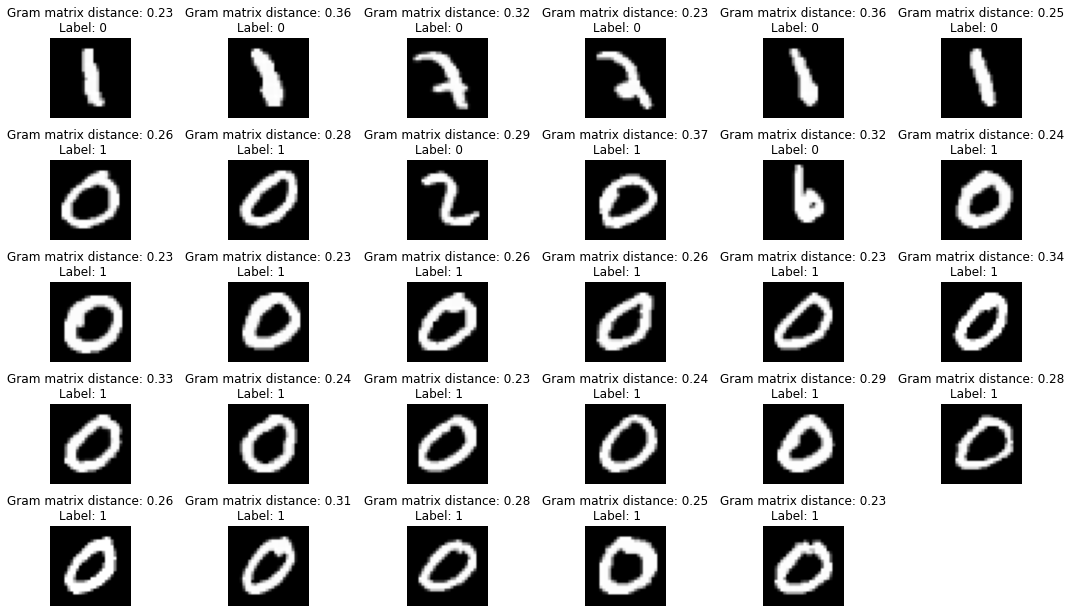

In [19]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

num_anomalies_to_visualize = 36
num_cols = 6
num_rows = num_anomalies_to_visualize // num_cols + 1

with torch.no_grad():
  for idx, oodIdx in enumerate(ood_indices[:num_anomalies_to_visualize]):
    image, label = mnist_test[oodIdx]
    plt.subplot(num_rows, num_cols, idx + 1)
    
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Gram matrix distance: {gram_matrix_list[idx]:.2f}\nLabel: {label}\
    ')
    plt.axis('off')

plt.tight_layout()
plt.show()

# References

[Github - awesome-anomaly-detection](https://github.com/hoya012/awesome-anomaly-detection#out-of-distributionood-detection-target)

[Calibrating Neural networks using temperature scaling & input processing](https://arxiv.org/pdf/1706.02690.pdf)

[Detecting OOD examples using Gram Matrices](https://arxiv.org/pdf/1912.12510.pdf)

